**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from model trained with tn nuclear data, further train the model with resized K's data through CroppingDataGenerator. <br>
200 epochs, CroppingDataGenerator, resized<br>
Best mAP  at mpp=

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
model_name = 'tn1.0_nuclear_K3' # the newly trained model
model_path = '{}.h5'.format(model_name)
INPUT_PATH="images/training_resized/"
epochs=200 # 20 sec per step 

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [3]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

7
['images/training_resized/M872956_JML_Position10_CD3_train_resized_img.png', 'images/training_resized/M872956_JML_Position9_CD3_train_resized_img.png', 'images/training_resized/M926910_CFL_Position13_CD3_train_resized_img.png', 'images/training_resized/M872956_JML_Position8_CD3_train_resized_img.png', 'images/training_resized/M872956_JML_Position8_CD8_train_resized_img.png', 'images/training_resized/M926910_CFL_Position7_CD3_train_resized_img.png', 'images/training_resized/M872956_JML_Position8_CD4_train_resized_img.png']


In [4]:
imgs = [io.imread(CURR_IM_NAME) for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

# np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs
# train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

2022-11-04 18:43:56.258988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-04 18:43:56.297862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-04 18:43:56.300662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(7, 2080, 2318, 1)
(7, 2080, 2318, 1)


In [5]:
# create dataloader
crop_size = (512, 512)

seed=1
min_objects = 2

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
# no need to define width_shift_range or height_shift_range 
# because crops will be taken randomly over the image and not just the center (cropping.py)
datagen = image_generators.CroppingDataGenerator(
    crop_size=(512, 512),
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)
    
datagen_val = image_generators.CroppingDataGenerator()

batch_size = 1 # there are only 7 images

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=0,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

12574


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


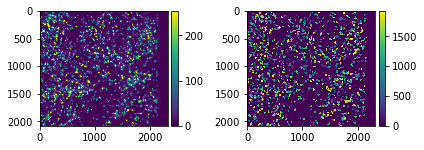

In [6]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [7]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

print([(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)])

2022-11-04 13:18:27.412461: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1)), ('semantic_2', (None, 512, 512, 2))]


In [8]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-04 13:18:34.645937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-04 13:18:34.647186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-04 13:18:34.648422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/200


2022-11-04 13:19:18.444746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


7/7 [==============================] - 105s 11s/step - loss: 0.0323 - semantic_0_loss: 0.0076 - semantic_1_loss: 0.0196 - semantic_2_loss: 0.0051 - lr: 1.0000e-04
Epoch 2/200
7/7 [==============================] - 85s 13s/step - loss: 0.0253 - semantic_0_loss: 0.0062 - semantic_1_loss: 0.0164 - semantic_2_loss: 0.0027 - lr: 9.9000e-05
Epoch 3/200
7/7 [==============================] - 86s 13s/step - loss: 0.0169 - semantic_0_loss: 0.0038 - semantic_1_loss: 0.0092 - semantic_2_loss: 0.0038 - lr: 9.8010e-05
Epoch 4/200
7/7 [==============================] - 84s 12s/step - loss: 0.0094 - semantic_0_loss: 0.0022 - semantic_1_loss: 0.0058 - semantic_2_loss: 0.0014 - lr: 9.7030e-05
Epoch 5/200
7/7 [==============================] - 85s 13s/step - loss: 0.0213 - semantic_0_loss: 0.0052 - semantic_1_loss: 0.0138 - semantic_2_loss: 0.0022 - lr: 9.6060e-05
Epoch 6/200
7/7 [==============================] - 85s 13s/step - loss: 0.0207 - semantic_0_loss: 0.0049 - semantic_1_loss: 0.0137 - semantic

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [7]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

2022-11-04 18:44:03.169770: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [8]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [11]:
# more detailed mapping of image_mpp parameter
mpps=np.linspace(start=.9, stop=1.4, num=6)

AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)
print(AP_mat)
print(mpps)
[x.index(np.max(x)) for x in AP_mat]

M926910_CFL_Position7_CD3_test_img.png


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


M872956_JML_Position10_CD3_test_img.png
M872956_JML_Position8_CD8_test_img.png
M926910_CFL_Position13_CD3_test_img.png
M872956_JML_Position8_CD3_test_img.png
M872956_JML_Position8_CD4_test_img.png
M872956_JML_Position9_CD3_test_img.png
[[0.18524590163934426, 0.23934426229508196, 0.29207920792079206, 0.337152209492635, 0.357487922705314, 0.3785488958990536], [0.18083182640144665, 0.25274725274725274, 0.3068391866913124, 0.34798534798534797, 0.39926062846580407, 0.45119705340699817], [0.24519230769230768, 0.3251231527093596, 0.3880597014925373, 0.4068627450980392, 0.40454545454545454, 0.42358078602620086], [0.09158415841584158, 0.13480392156862744, 0.1724137931034483, 0.1943127962085308, 0.23543123543123542, 0.23672566371681417], [0.2805755395683453, 0.34972677595628415, 0.4134078212290503, 0.4585635359116022, 0.4990791896869245, 0.5170556552962298], [0.4316353887399464, 0.47606382978723405, 0.568733153638814, 0.5728900255754475, 0.5700245700245701, 0.5584725536992841], [0.19875776397515

[5, 5, 5, 5, 5, 3, 5]

In [9]:
select_mpp=1.3

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
#     print(x.shape)
#     print(y.shape)
#     print(tile_info)
    pred = app.predict(y, image_mpp=select_mpp)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

2022-11-04 18:44:18.539290: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


{'M926910_CFL_Position7_CD3_test_img.png': 0.23934426229508196, 'M872956_JML_Position10_CD3_test_img.png': 0.25274725274725274, 'M872956_JML_Position8_CD8_test_img.png': 0.3251231527093596, 'M926910_CFL_Position13_CD3_test_img.png': 0.13480392156862744, 'M872956_JML_Position8_CD3_test_img.png': 0.34972677595628415, 'M872956_JML_Position8_CD4_test_img.png': 0.47606382978723405, 'M872956_JML_Position9_CD3_test_img.png': 0.25103734439834025, 'mAP': 0.2898352199231686}


In [13]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.359873
1  M872956_JML_Position10_CD3_test_img.png  0.433645
2   M872956_JML_Position8_CD8_test_img.png  0.401826
3  M926910_CFL_Position13_CD3_test_img.png  0.240826
4   M872956_JML_Position8_CD3_test_img.png  0.514706
5   M872956_JML_Position8_CD4_test_img.png  0.581281
6   M872956_JML_Position9_CD3_test_img.png  0.374486
7                                      mAP  0.415235


**mAP**<br>
image_mpp=1  : 0.29<br>
image_mpp=1.3: 0.415<br>